In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
%cd ..

In [53]:
from glob import glob
from PIL import Image
import numpy as np
import copy
import torch
from mmcv import Config
from torchpack.utils.config import configs
from mmdet3d.utils import recursive_eval
from mmdet3d.datasets import build_dataset
from typing import Any, Dict, List, Optional, Tuple, Union

In [ ]:
image_paths_1 = sorted(glob("data/tumtraf-i/train/images/s110_camera_basler_south1_8mm/*"))
image_paths_2 = sorted(glob("data/tumtraf-i/train/images/s110_camera_basler_south2_8mm/*"))

In [70]:
def create_grid_mask(img, prob):
    if np.random.rand() > prob:
        return img
    h = img.shape[0]
    w = img.shape[1]
    d1 = 2
    d2 = min(h, w)

    print("h: ", h, "w: ", w)
    hh = int(1.5 * h)
    ww = int(1.5 * w)
    d = np.random.randint(d1, d2)
    print("d: ", d, "d1: ", d1, "d2: ", d2)
    l = np.random.randint(1, d)
    print("l: ", l)
    mask = np.ones((hh, ww), np.float32)
    st_h = np.random.randint(d)
    st_w = np.random.randint(d)
    print("st_h: ", st_h, "st_w: ", st_w)
    for i in range(hh // d):
        s = d * i + st_h
        t = min(s + l, hh)
        mask[s:t, :] *= 0
    for i in range(ww // d):
        s = d * i + st_w
        t = min(s + l, ww)
        mask[:, s:t] *= 0

    r = np.random.randint(1)
    mask = Image.fromarray(np.uint8(mask))
    mask = mask.rotate(r)
    mask = np.asarray(mask)
    mask = mask[
        (hh - h) // 2 : (hh - h) // 2 + h, (ww - w) // 2 : (ww - w) // 2 + w
    ]

    mask = mask.astype(np.float32)
    mask = mask[:, :, None]
    mask = 1 - mask

    return img * mask 

def get_concat_v(im1, im2):
    dst = Image.new('RGB', (im1.width, im1.height + im2.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (0, im1.height))
    return dst

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

h:  256 w:  740
d:  107 d1:  2 d2:  256
l:  25
st_h:  76 st_w:  18
h:  256 w:  740
d:  107 d1:  2 d2:  256
l:  25
st_h:  76 st_w:  18


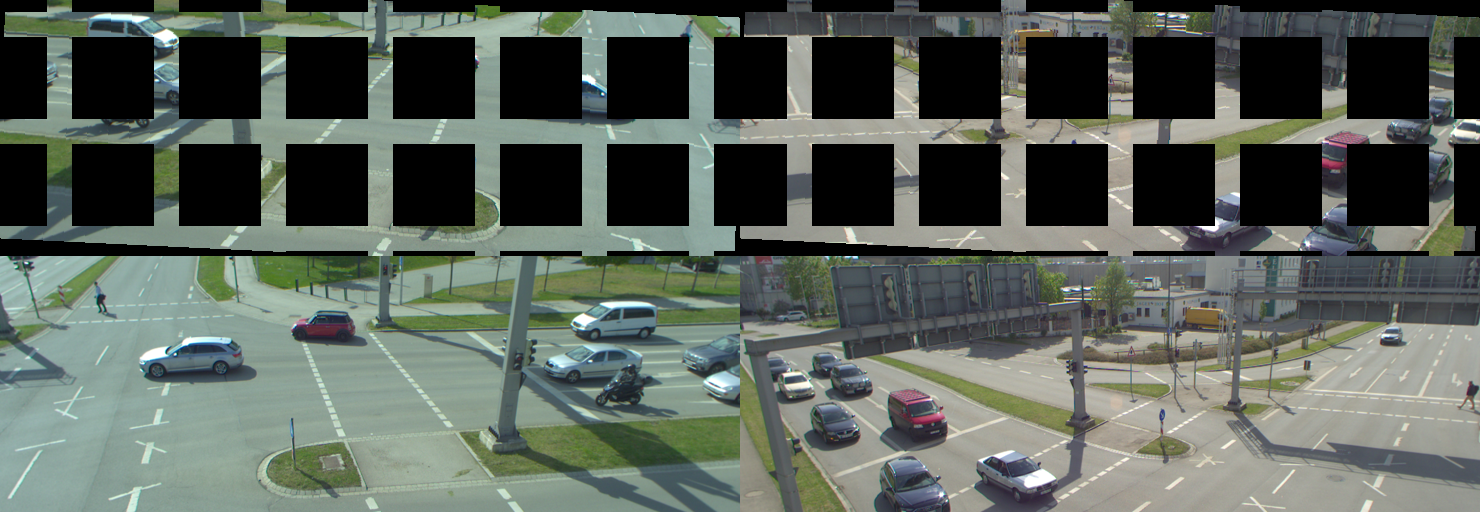

h:  256 w:  740
d:  107 d1:  2 d2:  256
l:  25
st_h:  76 st_w:  18
h:  256 w:  740
d:  107 d1:  2 d2:  256
l:  25
st_h:  76 st_w:  18


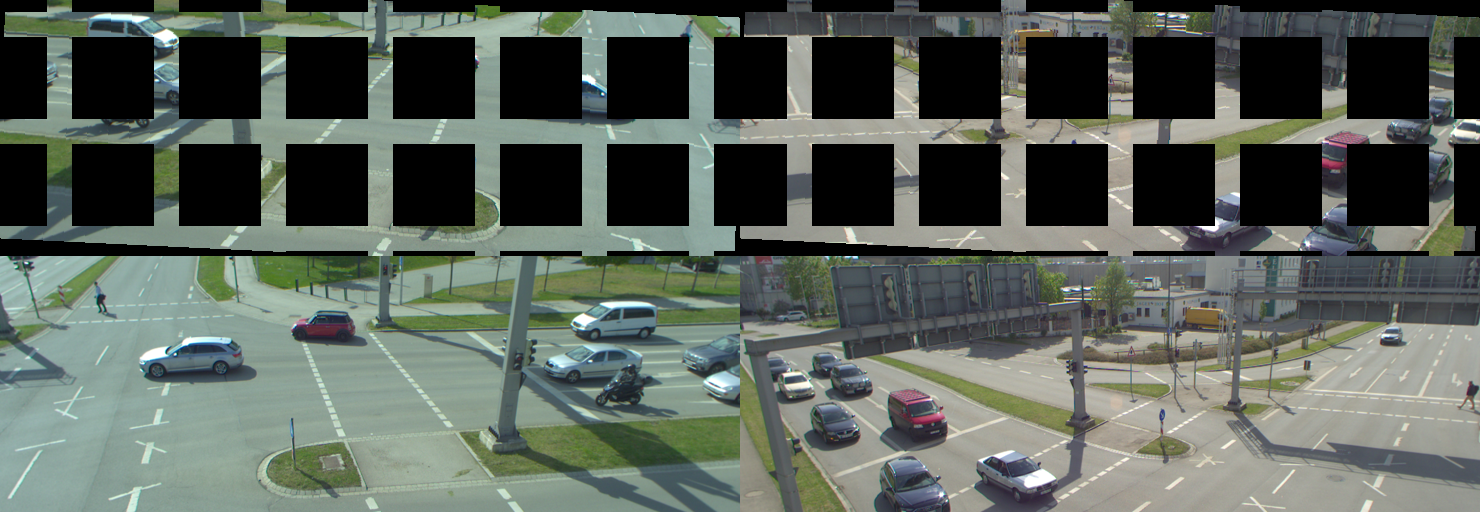

In [71]:
resize_lim = [[0.38, 0.55], [0.48, 0.48]]
rot_lim = [-5.4, 5.4]
gridmask_prob= 1.0
gridmask_fixed_prob = True
final_dim = [256,740]
rand_flip = True

def transform(img, test=False):
    W, H = img.size

    if test:
        fH, fW = final_dim
        resize = np.mean(resize_lim[1])
        resize_dims = (int(W * resize), int(H * resize))
        newW, newH = resize_dims
        crop_h = int((1 - np.mean(bot_pct_lim[1])) * newH) - fH
        crop_w = int(max(0, newW - fW) / 2)
        crop = (crop_w, crop_h, crop_w + fW, crop_h + fH)
        img = img.resize(resize_dims)
        img = img.crop(crop)
        return img

    fH, fW = final_dim
    resize = np.random.uniform(*resize_lim[0])
    resize_dims = (int(W * resize), int(H * resize))

    newW, newH = resize_dims
    crop_h = int((1 - np.random.uniform(*bot_pct_lim[0])) * newH) - fH
    crop_w = int(np.random.uniform(0, max(0, newW - fW)))

    crop = (crop_w, crop_h, crop_w + fW, crop_h + fH)
    rotate = np.random.uniform(*rot_lim)

    img = img.resize(resize_dims)
    img = img.crop(crop)
    
    if rand_flip and np.random.choice([0, 1]):
        img = img.transpose(method=Image.FLIP_LEFT_RIGHT)
    
    img = img.rotate(rotate)

    masked = create_grid_mask(np.uint8(img), gridmask_prob)
    img = Image.fromarray((masked).astype(np.uint8))
    
    return img

np.random.seed(42)
random_indices = np.random.randint(len(image_paths_1), size=1)

resize_lim = [[0.36, 0.44], [0.4, 0.4]]
bot_pct_lim = [[0.3, 0.5], [0.4, 0.4]]

for i in random_indices:
    img_1 = image_paths_1[i]
    img_1 = Image.open(img_1).convert("RGB")

    np.random.seed(i)
    img_1_train = transform(copy.deepcopy(img_1), False)
    img_1_test = transform(copy.deepcopy(img_1), True)
    img_1 = get_concat_v(img_1_train, img_1_test)

    img_2 = image_paths_2[i]
    img_2 = Image.open(img_2).convert("RGB")

    np.random.seed(i)
    img_2_train = transform(copy.deepcopy(img_2), False)
    img_2_test = transform(copy.deepcopy(img_2), True)
    img_2 = get_concat_v(img_2_train, img_2_test)
    img = get_concat_h(img_1, img_2)
    img.show()

resize_lim = [[0.36, 0.44], [0.4, 0.4]]
bot_pct_lim = [[0.3, 0.5], [0.4, 0.4]]

for i in random_indices:
    img_1 = image_paths_1[i]
    img_1 = Image.open(img_1).convert("RGB")

    np.random.seed(i)
    img_1_train = transform(copy.deepcopy(img_1), False)
    img_1_test = transform(copy.deepcopy(img_1), True)
    img_1 = get_concat_v(img_1_train, img_1_test)

    img_2 = image_paths_2[i]
    img_2 = Image.open(img_2).convert("RGB")

    np.random.seed(i)
    img_2_train = transform(copy.deepcopy(img_2), False)
    img_2_test = transform(copy.deepcopy(img_2), True)
    img_2 = get_concat_v(img_2_train, img_2_test)
    img = get_concat_h(img_1, img_2)
    img.show()


In [58]:
# import GridMask
from mmdet3d.datasets.pipelines.loading import LoadTemporalFiles
from mmdet3d.datasets.pipelines.transforms_3d import GridMask, ImageNormalize, ImageAug3D

_load = LoadTemporalFiles(
    queue_length=3,
    queue_range_threshold=1,
    load_images_vars={"to_float32": True},
    load_points_vars={
        "coord_type": "LIDAR",
        "load_dim": 5,
        "use_dim": 4,
        "reduce_beams": False,
        "load_augmented": False,
    },
    load_annotations_vars={
        "with_bbox_3d": True,
        "with_label_3d": True,
        "with_attr_label": False,
    },
)

_image_normalize = ImageNormalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    skip_normalize=True
)

_imgaug3d = ImageAug3D(
    final_dim= [256, 704],
    resize_lim= [0.4, 0.4],
    bot_pct_lim= [0.4, 0.4],
    rot_lim= [0.0, 0.0],
    rand_flip= False,
    is_train= False,
)

_grid_mask = GridMask(
    use_h=True,
    use_w=True,
    max_epoch=99,
    rotate=1,
    offset=False,
    ratio=0.5,
    mode=1,
    prob=1.0,
    fixed_prob=True,
    apply_same_aug_to_seq=False,
)

In [85]:
class CustomGridMask:
    def __init__(
        self,
        use_h,
        use_w,
        max_epoch,
        rotate=1,
        offset=False,
        ratio=0.5,
        mode=0,
        prob=1.0,
        fixed_prob=False,
        apply_same_aug_to_seq: bool = False,
    ):
        self.use_h = use_h
        self.use_w = use_w
        self.rotate = rotate
        self.offset = offset
        self.ratio = ratio
        self.mode = mode
        self.st_prob = prob
        self.prob = prob
        self.epoch = None
        self.max_epoch = max_epoch
        self.fixed_prob = fixed_prob
        self.apply_same_aug_to_seq = apply_same_aug_to_seq
        self.sample_aug = None

    def set_epoch(self, epoch):
        self.epoch = epoch
        if not self.fixed_prob:
            self.set_prob(self.epoch, self.max_epoch)

    def set_prob(self, epoch, max_epoch):
        self.prob = self.st_prob * self.epoch / self.max_epoch

    def sample_augmentation(self, h, w):
        if np.random.rand() > self.prob:
            return None
        
        print("h: ", h, "w: ", w)

        d1 = 2
        d2 = min(h, w)
        d = np.random.randint(d1, d2)

        print("d: ", d, "d1: ", d1, "d2: ", d2)

        if self.ratio == 1:
            l = np.random.randint(1, d)
        else:
            l = min(max(int(d * self.ratio + 0.5), 1), d - 1)

        print("l: ", l)

        st_h = np.random.randint(d)
        st_w = np.random.randint(d)

        print("st_h: ", st_h, "st_w: ", st_w)

        r = np.random.randint(self.rotate)
        print("r: ", r)

        offset_r = np.random.rand(h, w)

        print("offset_r.shape: ", offset_r.shape)

        return d, l, st_h, st_w, r, offset_r

    def apply(self, data: Dict[str, Any]) -> Dict[str, Any]:
        imgs = data["img"]

        h = imgs[0].shape[1]
        w = imgs[0].shape[2]

        if self.apply_same_aug_to_seq:
            if self.sample_aug is None:
                aug_vars = self.sample_augmentation(h, w)
                self.sample_aug = aug_vars
            else:
                aug_vars = self.sample_aug
        else:
            aug_vars = self.sample_augmentation(h, w)

        if aug_vars is None:
            return data

        d, l, st_h, st_w, r, offset_r = aug_vars

        hh = int(1.5 * h)
        ww = int(1.5 * w)
        mask = np.ones((hh, ww), np.float32)

        if self.use_h:
            for i in range(hh // d):
                s = d * i + st_h
                t = min(s + l, hh)
                mask[s:t, :] *= 0
        if self.use_w:
            for i in range(ww // d):
                s = d * i + st_w
                t = min(s + l, ww)
                mask[:, s:t] *= 0

        mask = Image.fromarray(np.uint8(mask))
        mask = mask.rotate(r)
        mask = np.asarray(mask)
        mask = mask[(hh - h) // 2 : (hh - h) // 2 + h, (ww - w) // 2 : (ww - w) // 2 + w]

        mask = mask.astype(np.float32)
        mask = mask[None, :, :]
        if self.mode == 1:
            mask = 1 - mask

        # mask = mask.expand_as(imgs[0])
        if self.offset:
            offset = torch.from_numpy(2 * (offset_r - 0.5)).float()
            offset = (1 - mask) * offset
            imgs = [x * mask + offset for x in imgs]
        else:
            imgs = [x * mask for x in imgs]

        data.update(img=imgs)
        return data

    def apply_temporal(self, data: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
        for i, frame_data in enumerate(data):
            data[i] = self.apply(frame_data)
        self.sample_aug = None
        return data

    def __call__(
        self, data: Union[dict, List[Dict[str, Any]]]
    ) -> Union[dict, List[Dict[str, Any]]]:
        if isinstance(data, list):
            return self.apply_temporal(data)
        else:
            return self.apply(data)


_custom_grid_mask = CustomGridMask(
    use_h=True,
    use_w=True,
    max_epoch=99,
    rotate=1,
    offset=False,
    ratio=0.5,
    mode=1,
    prob=1.0,
    fixed_prob=True,
    apply_same_aug_to_seq=False,
)

In [75]:
config_path = "configs/tumtraf-i/temporal/transfusion/lidar/voxelnet-1600g-0xy1-0z20-ql3-qrt2-gtp15.yaml"
configs.load(config_path, recursive=True)
cfg = Config(recursive_eval(configs), filename=config_path)
dataset = build_dataset(cfg.data.train, dict(test_mode=False))

h:  256 w:  704
d:  78 d1:  2 d2:  256
l:  39
st_h:  60 st_w:  21
r:  0
offset_r.shape:  (256, 704)


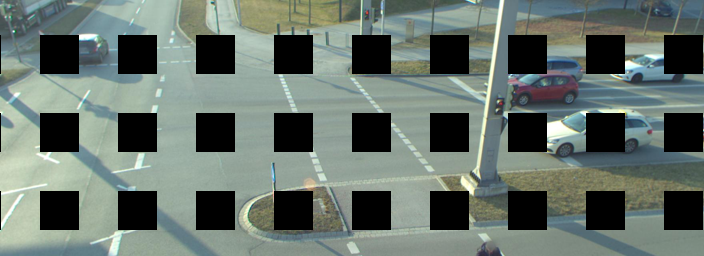

h:  256 w:  704
d:  31 d1:  2 d2:  256
l:  16
st_h:  3 st_w:  24
r:  0
offset_r.shape:  (256, 704)


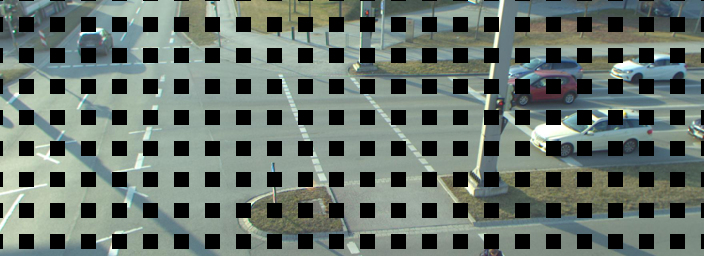

In [90]:
idx = 0
for x in range(2):
    sample = dataset.dataset.get_data_info(x)
    dataset.dataset.pre_pipeline(sample)

    sample = _load(sample)
    sample = _imgaug3d(sample)
    sample = _image_normalize(sample)
    sample = _custom_grid_mask(sample)
    img:torch.tensor = sample["img"][0]

    # show image
    img = img.numpy() * 255
    img = np.transpose(img, (1, 2, 0))
    img = Image.fromarray(np.uint8(img))
    img.show()
